In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('sp500_data.csv')

# Filter the dataframe to only contain ticker 'NVDA'
df = df[df['Ticker'] == 'NVDA']

# Reset the index after filtering
df = df.reset_index(drop=True)

# Drop the 'Ticker' column
df = df.drop('Ticker', axis=1)

# Convert 'Date' to Unix timestamp
df['Date'] = pd.to_datetime(df['Date']).astype('int64') / 10**6

# Define features (X) and target variable (y)
X = df.drop('Close', axis=1)  # Assuming 'Close' is the target variable
y = df['Close']


# Normalize the features using StandardScaler
# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to DataFrame to keep column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Further split train+validation into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print("Filtered dataframe for NVDA:")
print(f"Total rows for NVDA: {len(df)}")
X_train.head()


Train set shape: (4136, 6)
Validation set shape: (1034, 6)
Test set shape: (1293, 6)
Filtered dataframe for NVDA:
Total rows for NVDA: 6463


,Date,Open,High,Low,Adj Close,Volume
4728,0.801243,-0.094832,-0.098022,-0.091721,-0.094691,-0.581203
1806,-0.763479,-0.352362,-0.351425,-0.352719,-0.352071,0.886981
6290,1.640291,2.868579,2.825413,2.886720,2.887357,-0.717917
3051,-0.096524,-0.350514,-0.350596,-0.351345,-0.351930,1.656192
991,-1.199991,-0.371614,-0.371349,-0.372389,-0.370724,1.618098


Epoch [10/100], Train Loss: 592.9159, Val Loss: 332.8997
Epoch [20/100], Train Loss: 33.4322, Val Loss: 247.0067
Epoch [30/100], Train Loss: 195.9704, Val Loss: 179.7088
Epoch [40/100], Train Loss: 64.5846, Val Loss: 127.5297
Epoch [50/100], Train Loss: 11.9256, Val Loss: 88.0555
Epoch [60/100], Train Loss: 13.3468, Val Loss: 59.0134
Epoch [70/100], Train Loss: 14.4705, Val Loss: 38.5084
Epoch [80/100], Train Loss: 9.3241, Val Loss: 24.3997
Epoch [90/100], Train Loss: 8.0144, Val Loss: 15.0825
Epoch [100/100], Train Loss: 12.4607, Val Loss: 8.9844
Validation MSE: 8.9844
Validation R2 Score: 0.9777


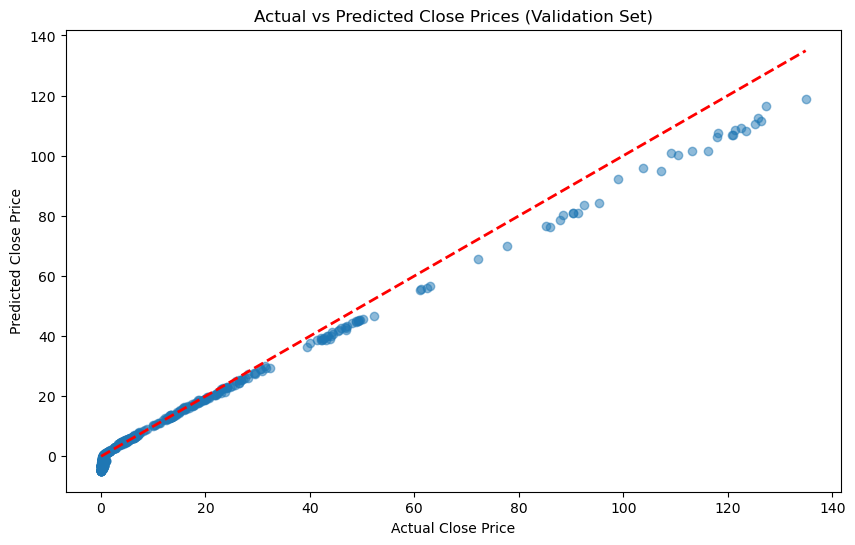

In [15]:
# Define the simple regression model
class SimpleRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val.values).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the model
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1

model = SimpleRegressionModel(input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Evaluate on validation set
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor).cpu().numpy()
    val_mse = mean_squared_error(y_val, val_predictions)
    val_r2 = r2_score(y_val, val_predictions)

print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation R2 Score: {val_r2:.4f}")

# Plot actual vs predicted values for validation set
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("Actual vs Predicted Close Prices (Validation Set)")
plt.show()


In [27]:
# Import necessary libraries
import yfinance as yf
from datetime import datetime, timedelta

# Get the latest data for the stock
ticker = "NVDA"
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d')  # Get 60 days of data

# Fetch the data
df = yf.download(ticker, start=start_date, end=end_date)

# Prepare the input data (use the same feature engineering as in training)
latest_data = df.tail(1).copy()  # Get only the last row
latest_data['Date'] = (latest_data.index.astype('int64') / 10**6).astype('int64')

# Ensure we have the same columns as during training
for col in X_train.columns:
    if col not in latest_data.columns:
        latest_data[col] = 0  # or some appropriate default value

# Reorder columns to match training data
latest_data = latest_data[X_train.columns]

# Scale the data using the same scaler used for training
latest_scaled = scaler.transform(latest_data)

# Convert to tensor
latest_tensor = torch.FloatTensor(latest_scaled).to(device)

# Make prediction
model.eval()
with torch.no_grad():
    prediction = model(latest_tensor).item()

# Denormalize the prediction
predicted_price = prediction * y_train.std() + y_train.mean()

print(f"Predicted close price for {ticker} on {(datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')}: ${predicted_price:.2f}")


[*********************100%%**********************]  1 of 1 completed
Predicted close price for NVDA on 2024-09-29: $1965.60


c:\Users\Charlie Yin\.conda\envs\mariorl\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
